In [1]:
# импорт пакетов
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)

pd.options.mode.chained_assignment = None



In [6]:
df = pd.read_csv("data.csv")
# Посмотрим с какими данными нам работать
print(df.shape)
print(df.dtypes)

# отбор числовых колонок
df_numeric = df.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
print(numeric_cols)

# отбор нечисловых колонок
df_non_numeric = df.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values
print(non_numeric_cols)


(377185, 18)
status          object
private pool    object
propertyType    object
street          object
baths           object
homeFacts       object
fireplace       object
city            object
schools         object
sqft            object
zipcode         object
beds            object
state           object
stories         object
mls-id          object
PrivatePool     object
MlsId           object
target          object
dtype: object
[]
['status' 'private pool' 'propertyType' 'street' 'baths' 'homeFacts'
 'fireplace' 'city' 'schools' 'sqft' 'zipcode' 'beds' 'state' 'stories'
 'mls-id' 'PrivatePool' 'MlsId' 'target']


status - тип заявки
private pool - бассейн
price - цена
propertyType - тип строения
street - улица
baths - сколько туалетов / душевых
homeFacts - Краткий обзор признаков
fireplace - пожарная лестница (место для пожарных)
city - город
schools - школы
sqft - квадратные футы
zipcode - zipcode
beds - кроватей
state - штат
stories - магазины
mls-id - id для риэлторов (https://en.wikipedia.org/wiki/Multiple_listing_service)
PrivatePool - приватный бассейн
MlsId - еще вариант id для риэлторов

Тепловая карта пропущенных значений

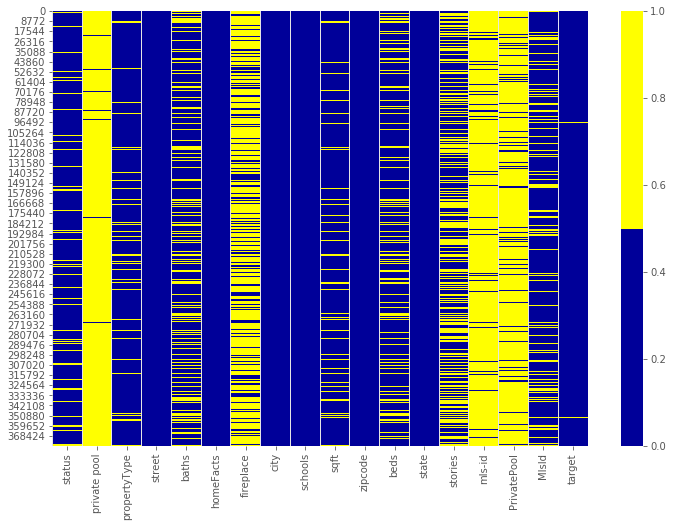

In [7]:
cols = df.columns 
# определяем цвета 
# желтый - пропущенные данные, синий - не пропущенные
colours = ['#000099', '#ffff00'] 
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))

Удалим колонки с пропушенными значениями

In [8]:
df.drop( [ 'stories', 'mls-id', 'MlsId','private pool','PrivatePool','fireplace'], axis='columns', inplace=True) 

Процентный список пропущенных данных

In [9]:
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

status - 11.0%
propertyType - 9.0%
street - 0.0%
baths - 28.0%
homeFacts - 0.0%
city - 0.0%
schools - 0.0%
sqft - 11.0%
zipcode - 0.0%
beds - 24.0%
state - 0.0%
target - 1.0%


In [10]:
# удаляем колонки пропущенными значениями > 20%
df.drop( [ 'baths', 'beds'], axis='columns', inplace=True) 

Гистограмма пропущенных данных

Пропущенные значения для : status
Пропущенные значения для : propertyType
Пропущенные значения для : street
Пропущенные значения для : city
Пропущенные значения для : sqft
Пропущенные значения для : target


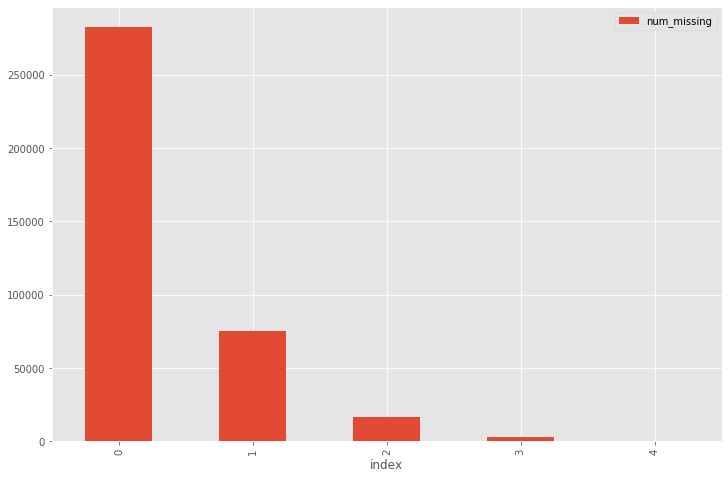

In [11]:
# сначала создаем индикатор для признаков с пропущенными данными
for col in df.columns:
    missing = df[col].isnull()
    num_missing = np.sum(missing)
    
    if num_missing > 0:  
        print('Пропущенные значения для : {}'.format(col))
        df['{}_ismissing'.format(col)] = missing


# затем на основе индикатора строим гистограмму
ismissing_cols = [col for col in df.columns if 'ismissing' in col]
df['num_missing'] = df[ismissing_cols].sum(axis=1)

df['num_missing'].value_counts().reset_index().sort_values(by='index').plot.bar(x='index', y='num_missing')


Отсюда понятно, что из 360 тыс. записей более 250 тыс. строк не имеют ни одного пропущенного значения, 
а еще около 70 тыс.– всего одно. Такие строки можно использовать в качестве «эталонных» 
для проверки различных гипотез по дополнению данных.

Отбрасывание записей
Например, из гистограммы, построенной в предыдущем разделе, мы узнали, что лишь небольшое количество строк содержат более 1 пропусков. Мы можем создать новый набор данных df_less_missing_rows, в котором отбросим эти строки.

In [12]:
# отбрасываем строки с большим количеством пропусков
ind_missing = df[df['num_missing'] > 1].index
df_less_missing_rows = df.drop(ind_missing, axis=0)

In [13]:
def replacestatus(x):
    if x == np.nan:
        return x
    
    x = str(x).upper()
    х = str(x).strip()
    if x == 'C':
        x ='CONTINUE SHOW'
        
    x = x.replace('UNDER CONTRACT SHOW','UNDER CONTRACT - SHOW')
    x = x.replace('UNDER CONTRACT   SHOWING','UNDER CONTRACT - SHOW')
    x = x.replace('RE ACTIVATED','REACTIVATED')
    x = x.replace('CONTINGENT   SHOW'     ,'CONTINGENT SHOW')
    x = x.replace('/ AUCTION' , 'AUCTION')
    x = x.replace('A ACTIVE' , 'ACTIVE')
    x = x.replace('ACTIVE/CONTINGENT', 'ACTIVE CONTINGENT')
    x = x.replace('C CONTINUE SHOW', 'CONTINUE SHOW')
    x = x.replace('U UNDER CONTRACT', 'UNDER CONTRACT')
    x = x.replace('P PENDING SALE', 'PENDING')
    x = x.replace('NEW CONSTRUCTION','NEW')
    x = x.replace('PENDING   CONTINUE TO SHOW', 'PENDING CONTINUE TO SHOW')
    
    x = x.replace("'" , '')
    х = str(x).strip()
    
    if x.find('COMING SOON') != -1 :
           x = 'COMING SOON'

    if x.find('SOLD') != -1 :
           x = 'SOLD'
             
    x = str(x).strip()
    return x

In [14]:
df['status2'] = df.apply(lambda x: replacestatus(x['status']), axis = 1)

In [15]:
def replaceProperty(x):
    if x == np.nan:
        return x
    
    x = str(x).upper()
    х = str(x).strip()
    x = x.replace('SINGLE-FAMILY HOME','SINGLE FAMILY')
    x = x.replace('SINGLE FAMILY HOME','SINGLE FAMILY')
    x = x.replace('MULTI-FAMILY HOME','MULTI FAMILY')
    x = x.replace('MULTI-FAMILY'     ,'MULTI FAMILY')
    x = x.replace('SPLIT-LEVEL' , 'SPLIT LEVEL')
    x = x.replace('OTHER - SEE REMARKS' , 'OTHER (SEE REMARKS)')
    x = x.replace('OTHER STYLE' , 'OTHER')
    x = x.replace('PATIO HOME' , 'PATIO')
    x = x.replace('MOBILE / MANUFACTURED' , 'MOBILE/MANUFACTURED')
    x = x.replace('MID-CENTURY MODERN'  , 'MID CENTURY MODERN')
    x = x.replace('LOG HOME' , 'LOG')
    x = x.replace('HISTORICAL' , 'HISTORIC')
    x = x.replace('HIGH RISE' , 'HIGH-RISE')
    x = x.replace('FARM HOUSE' , 'FARMHOUSE')
    x = x.replace('BILEVEL' , 'BI-LEVEL')
    x = x.replace('CARRIAGE HOUSE' , 'CARRIAGE')
    x = x.replace('CUSTOM HOME' , 'CUSTOM')
    x = x.replace("'" , '') 
    х = str(x).strip()
    return x #.split(',')[0]

In [16]:
df['propertyType2'] = df.apply(lambda x: replaceProperty(x['propertyType']), axis = 1)

In [17]:
df.columns

Index(['status', 'propertyType', 'street', 'homeFacts', 'city', 'schools',
       'sqft', 'zipcode', 'state', 'target', 'status_ismissing',
       'propertyType_ismissing', 'street_ismissing', 'city_ismissing',
       'sqft_ismissing', 'target_ismissing', 'num_missing', 'status2',
       'propertyType2'],
      dtype='object')

Вытащим данные из колонки 'homeFact'

В колонке homeFacts храняться данные о год постройки, паркинге, кухне, стоимости за квадратный фут (sqft), размере дома {'atAGlanceFacts': [{'factValue': '1961', 'factLabel': 'Year built'}, {'factValue': '1967', 'factLabel': 'Remodeled year'}, {'factValue': 'Forced Air', 'factLabel': 'Heating'}, {'factValue': 'Central', 'factLabel': 'Cooling'}, {'factValue': 'Attached Garage', 'factLabel': 'Parking'}, {'factValue': '8,626 sqft', 'factLabel': 'lotsize'}, {'factValue': '$965/sqft', 'factLabel': 'Price/sqft'}]}

вынесем эти данные в новые колонки

In [18]:
def add_homeFacts(x):
    ls1 =x.replace("{'atAGlanceFacts': [", "").replace(']}','').replace("{'factValue':",'').replace("'factLabel':",'').split('}')
    _l =[np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]
    if len(ls1)>=7 :
            _l[0]=ls1[0].split(',')[0] #Yearbuilt
            _l[1]=ls1[1].split(',')[1]  # Remodeledyear
            _l[2] = ls1[2].split(',')[1] # Heating
            _l[3] = ls1[3].split(',')[1] # Cooling
            _l[4] = ls1[4].split(',')[1] # Parking
            _l[5] = ls1[5].split(',')[1].replace("sqft",'') # lotsize
            _l[6] = ls1[6].split(',')[1].replace("/sqft",'').replace("$",'').replace( '/ Sq. Ft.','').replace(" ",'') # Pricesqft
    return _l

In [19]:
df['Yearbuilt'] = df.apply(lambda x: add_homeFacts(x['homeFacts'])[0], axis = 1)
df['Remodeledyear'] = df.apply(lambda x: add_homeFacts(x['homeFacts'])[1], axis = 1)
df['Heating'] = df.apply(lambda x: add_homeFacts(x['homeFacts'])[2], axis = 1)
df['Cooling'] = df.apply(lambda x: add_homeFacts(x['homeFacts'])[3], axis = 1)
df['Parking'] = df.apply(lambda x: add_homeFacts(x['homeFacts'])[4], axis = 1)
df['lotsize'] = df.apply(lambda x: add_homeFacts(x['homeFacts'])[5], axis = 1)
df['Pricesqft'] = df.apply(lambda x: add_homeFacts(x['homeFacts'])[6], axis = 1)

In [20]:
def replacePricesqft(x):
    if x == np.nan:
        return x
    
    x = str(x).upper()
    х = str(x).strip()
    x = x.replace(str('/ Sq. Ft.').upper() , '')
    x = x.replace(str('Sq. Ft.').upper() , '')
    x = x.replace(str('lot').upper() , '')
    x = x.replace(str('acres').upper() , '')
    x = x.replace(str('-').upper() , '')
    x = x.replace(str('Acres').upper() , '')
    x = x.replace(str('ACRE').upper() , '')
    x = x.replace('+' , '')
    x = x.replace("'" , '') 
    x = x.replace(" " , '')
    
    x = str(x).strip()
    return x
    #if str(x).isnumeric():
    #    return float(x)
    #else:
    #    return 0

In [21]:
df['Pricesqft2'] = df.apply(lambda x: replacePricesqft(x['Pricesqft']), axis = 1)
df['lotsize'] = df.apply(lambda x: replacePricesqft(x['lotsize']), axis = 1)

Для анализа школы возьмем данные по ближайшей. В качестве улучшения модели можно добавить среднее, общее количество.

"[{'rating': ['8/10', '4/10', '8/10'], 'data': {'Distance': ['1.19mi', '2.06mi', '2.63mi'], 'Grades': ['6-8', 'K-5', '9-12']}, 'name': ['Paul Revere Middle School', 'Brentwood Science School', 'Palisades Charter High School']}]"

In [23]:
def add_schools(x):
    _lsp= x.replace(' ','').replace("'rating':",'|').replace("'data':",'|').replace("'name':",'|').replace('[{','').replace('}]','').split('|')
    #print (_lsp)
    _rating=_lsp[1].replace(']','').replace('[','').split(',')
    _llsp2= _lsp[2].replace("'Distance':",'|').replace("'Grades':",'|').split('|')
    _Distance = _llsp2[1].replace(']','').replace('[','').replace('mi','').replace("'",'').split(',')
    _Grades = _llsp2[2].replace(']}','').replace('[','').split(',')

    _minDistance = 0.
    _minrating = np.nan
    _minGrades = 'NR'

    for i in range(0,len(_Distance)):
        #print (_Distance[i])
        if _Distance[i] == '':
            continue
        
        if _minDistance == 0:
            _minDistance = float(_Distance[i])
            _minrating = _rating[i]
            if i <len(_Grades):
                _minGrades = _Grades[i]
            else:
                _minGrades = 'NR'
        
        if float(_Distance[i]) < _minDistance:
            _minDistance =float(_Distance[i])
            _minrating = _rating[i]
            if i <len(_Grades):
                _minGrades = _Grades[i]
            else:
                _minGrades = 'NR'

    return (_minrating,_minDistance,  _minGrades)   

In [24]:
df['rating1'] = df.apply(lambda x: add_schools(x['schools'])[0], axis = 1)
df['Distance1'] = df.apply(lambda x: add_schools(x['schools'])[1], axis = 1)
df['Grades1'] = df.apply(lambda x: add_schools(x['schools'])[2], axis = 1)

In [31]:
def replace1(x):
   if x == np.nan:
        return x
    
   x = str(x).replace("'" , '')
   x = str(x).replace(" " , '')
   return x

df['Yearbuilt'] = df.apply(lambda x: replace1(x['Yearbuilt']), axis = 1)
df['Remodeledyear'] = df.apply(lambda x: replace1(x['Remodeledyear']), axis = 1)
df['Distance1'] = df.apply(lambda x: replace1(x['Distance1']), axis = 1)
df['lotsize'] = df.apply(lambda x: replace1(x['lotsize']), axis = 1)
#df['baths2'] = df.apply(lambda x: replace1(x['baths2']), axis = 1)
df['sqft2'] = df.apply(lambda x: replace1(x['sqft']), axis = 1)

def replace_to(x):
   if x == np.nan:
        return x
    
   x = str(x).replace("'" , '')
   x = str(x).replace("to" , '-')
   x = str(x).replace(" " , '')
   x = str(x).replace("nan" , '0')
   x = str(x).replace("None" , '0')
   x = str(x).replace("NR" , '0')
   x = str(x).replace("NA" , '0')
   return x

df['Grades1'] = df.apply(lambda x: replace_to(x['Grades1']), axis = 1)
df['rating1'] = df.apply(lambda x: replace_to(x['rating1']), axis = 1)

def replace_city(x):
   x = str(x).replace("'" , '')
   x = str(x).replace(" " , '')
   x = str(x).replace("." , '')
   x = str(x).replace("-" , '')
   x = str(x).upper()
   х = str(x).strip() 
   return x

df['city'] = df.apply(lambda x: replace_city(x['city']), axis = 1)

def replace_zip(x):
   x = str(x).split("-")[0]
   return x

df['zipcode'] = df.apply(lambda x: replace_zip(x['zipcode']), axis = 1)


In [36]:
df['Heating'] = df.apply(lambda x: replace1(x['Heating']), axis = 1)
df['Cooling'] = df.apply(lambda x: replace1(x['Cooling']), axis = 1)
df['Parking'] = df.apply(lambda x: replace1(x['Parking']), axis = 1)


In [32]:
def replacetarget(x):
    if x == np.nan:
        return x
    
    x = str(x).upper()
    х = str(x).strip()
    x = x.replace('$' , '')
    x = x.replace(',' , '')
    x = x.replace('+' , '')
    x = x.replace('/MO' , '')
    x = x.replace("'" , '')   
    x = str(x).strip()
    return x

In [33]:
df['target2'] = df.apply(lambda x: replacetarget(x['target']), axis = 1)

In [34]:
def replacesqft(x):
    if x == np.nan:
        return x
    
    x = str(x).upper()
    х = str(x).strip()
    x = x.replace(str('Totalinteriorlivablearea:').upper() , '')
    x = x.replace(',' , '')
    x = x.replace('+' , '')
    x = x.replace("'" , '')
    x = x.replace(str('sqft').upper() , '')
       
    x = str(x).strip()
    return x

In [35]:
df['sqft2'] = df.apply(lambda x: replacesqft(x['sqft2']), axis = 1)

In [37]:
df.columns

Index(['status', 'propertyType', 'street', 'homeFacts', 'city', 'schools',
       'sqft', 'zipcode', 'state', 'target', 'status_ismissing',
       'propertyType_ismissing', 'street_ismissing', 'city_ismissing',
       'sqft_ismissing', 'target_ismissing', 'num_missing', 'status2',
       'propertyType2', 'Yearbuilt', 'Remodeledyear', 'Heating', 'Cooling',
       'Parking', 'lotsize', 'Pricesqft', 'Pricesqft2', 'rating1', 'Distance1',
       'Grades1', 'target2', 'sqft2'],
      dtype='object')

In [124]:
def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    print('Нижняя граница:', lower_bound, 'Верхняя граница:', upper_bound)
    return np.where((ys > upper_bound) | (ys < lower_bound))[0]

o_price = outliers_iqr(df.target2)

len(o_price), len(o_price)/df.shape[0]

Нижняя граница: -405000.0 Верхняя граница: 1275000.0


(8058, 0.10757626326680463)

In [ ]:
Посмотим на итоговые пропущенные значения

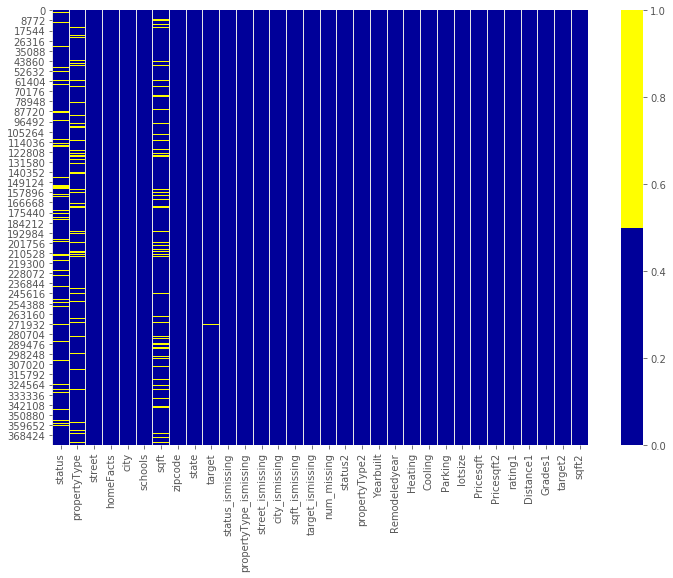

In [38]:
cols = df.columns 
# определяем цвета 
# желтый - пропущенные данные, синий - не пропущенные
colours = ['#000099', '#ffff00'] 
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))

In [39]:
# Просмотрим данные по колонкам и удалим грязные 
colname = 'city'
#colname ='street'
#colname ='baths'
#colname ='fireplace' # ???
#colname ='homeFacts'
#colname ='schools'
#colname ='sqft2'
#colname ='beds'
#colname ='PrivatePool'
#colname ='private pool'
#colname ='stories' # ????
#colname ='MlsId'
#colname ='target2'
#colname ='status2'
#colname = 'propertyType2'
#colname = 'lotsize'
#colname = 'lotsize'
baths = pd.DataFrame(df[colname].value_counts())
#print(type(baths))
baths =baths.sort_index(ascending=False)
for i in baths.index:
    print(i)

—
NONE
NODATA
9999
9998
9997
9996
9995
9994
9993
9990
999.00
999
9989
9988
9986
9985
9984
9983
9982
9980
998
9979
9976
99752
9975
9974
9973
99725
9971
9970
997
9969
9967
9966
9963
996217
9962
9961
9960
996
9958
9957
9950
995
9949
9948
9945
9944
9941
9940
994
9938
9937
993604
9933
9932
99317
993168
9931
9930
993
9928
9927
9926
9923
992297
9922
9920
992
9918
9915
9914
9911
9910
991
9909
9907
990554
9905
9904
9901
9900
990
99.66
9899
9898
9897
9896
9893
9892
98914
98911
98906
989
98881
9888
9884
988376
9883
988
987941
98794
9879
9878
9875
9874
9873
9872
9870
987
9868
9867
9866
9865
9864
9862
9861
986
9859
9858
98578
9857
9853
9850
985
9849
9845
98446
9844
9842
9840
984
98380
9838
983585
9835
9834
9831
983
9828
9826
9825
9822
9820
9818
9816
9814
9812
9811
9810
981
980971
9809
9806
98054
9805
9804
980100
98010
9801
9800
980
98.81
98.00
98
9797
979664
9796
9795
9791
979
9787
9786
9785
9783
9781
978
9779
9778
9775
977486
9774
9770
977
9769
9766
9765
9764
9762
9761
9760
976
9758
975744
97574
9

7881
7880
788
7879
7877
7876
7875
7874
7872
7871292
7871
787
7868
7865
7863
7862
7861
7860
786
7858
7856
7854
78539
785387
7853
7852
7850
785
7849
7847
7845
7841
784080
78408
784000
7840
784.08
784
7839
783692
783644
7836
7832
7830
783
7828
782773
7826
7824
7823
7822
7821
7820
782
7819
7818
7817
7815
781466
7814
7812
7810
781
7809
7808
7807
7806
7805
7802
7801
7800
780
78.50
78.40
78.4
78.00
78
7799
7798
779724
77972
7797
7795
7793
7792
77912
7791
779
7789
7788
7787
778417
7784
7780
778
7779
7775
7774
7773282
7772
7771
7770
777
7769
7768
7767
7765
7763
7762
7760
776
7758
7756
7754
77537
775368
7753
7750
775
7749
7748
7747
7746
7745
7744
7743
7741
7740
774
7739
77375
7736
7735
7733
7732
7731
773
7729
7727
7726
7725
7724
7723
7721
7720
772
7718
7717
7715
77144
7714
7712
7711
77101
7710
771
7707
7706
7705
7703
7702
7701
7700
770
77.64
77.52
77.37
77.21
77.09
77.00
77
7699
7698
7697
7695
7693
7692
769
76883
7688
7687
768616
7686
7685
7684
768398
7682
7681
7680
768
7679
7678
7677
76753
7675

55782
55770
5576
55757
557568
5575
5573
55714
557132
55713
5571
557
5569
5568
5567
5566
5563
556261
5562
5561
556
5559
555825
5558
55578
555390
5553
5552
5550
555
554954
5549
55484
5548
5547
5546
554519
5545
5544
5542
5541
5540
554
5539
55370
55365
5536
553212
55321
5532
5531
5530
553
5529
5528
5524
552341
5523
55208
5520
552
551905
5519
5518
55162
5515
5512
55112
551034
5510
551
5509
55088
5507
5506
550598
5505
5504
5503
5502
5501
5500
550
55.99
55.95
55.89
55.78
55.70
55.3
55.07
55.02
55.00
55.0
55
5499
54972
5497
5495
5494
5492
5490
549
5489
54886
5488
5485
548420
54842
54829
5482
5481
5480
548
547985
5479
5478
547549
5475
5471
547
5469
5467
54668
5466
5465909
546460
5464
5463
546242
5462
5461
5460
54592
5459
545807
54580
5458
5456
5454
54520
5450
545
5449
5448
5447
5446
5445000
544500
54450
5445
5442
5441
544
5439
54378
5436
54340
5434
5433
543193
54319
5430
543
5428
5427
5425398
5425
5424
542322
5423
5422
542.00
542
5418
5416
541451
5414
5412
5411
54102
541015
5410
5408
5407
5406


36439
3642
36416
364118
3641
3640
364
3637696
3637260
363726
3637
3636
3635
363290
3632
3630
363
3629
36286
362855
36285
3628
36279
3627
3625
3624
36238
3622
3621
3620
362
36198
3619
36155
361548
3615
3614
36106
36100
361
36075
3607
36068
36048
3602
3600
360.00
360
36.95
36.94
36.70
36.60
36.58
36.53
36.48
36.2
36.13
36.11
36.08
36.00
36
35981
3598
3597
359598
35948
3594
3593700
359370
35937
3593
3592393
35919
3591
3589344
358934
3589
3588
3586
358499
35846
3584
35824
35820
3580
358
357628
3576
35741
3574098
3573662
3572
3571920
357192
35719
3571
35705
357
3569
35688
3567
35645
3564
35634
35631
3562
3561
3560
356
3559
35587
3558
355450
35544960
3554
35536
35510
355014
35501
3550
3549704
35462
35458
354578
3545
3541
3540
354
35387
3537943
3537
3534894
353272
35321
3532
35306
3530
353
35284
3528360
352836
3528
35278
35271
3527
35265
3525
352400
35227
35215
3521
3520
352
351965
3519
35181
35175
3517
35169
351660
35165
35153
351529
3515
3514856
3514421
3513
3511
3510936
3510
351.54
351
350

2665
2664130
2662
266152
2661
26607
26600
266
26585
2658
26572
2657160
265716
2657
26569
2656
2653
265280
26523
2652
2650
265
2649
264845
26484
2648
264772
2647141
2647
2646
264409
26408
264061
2640
264.00
264
263974
2639
2638
2637
263538
2635
26349
2634
26336
263102
2631
26308
263.00
263
26284
2628
2627
2626232
2626
26250
2625
26249
26239
26232
262231
2622
26214
262101
2621
26208
262
26198
26195
26188
261796
2617
26162
2615778
2615
2614
26136000
2613600
261360
26136
26132
2613164
2613
261284
26125
2612
26111
2611
261000
261
260924
26092
2609
26085
26082
26068
2605324
26049
260489
26046
2604
26027
2602
26010
2601
260097
260053
26005
26004
26001
26000
2600
260
26.98
26.92
26.87
26.86
26.75
26.60
26.55
26.53
26.50
26.48
26.45
26.41
26.36
26.23
26.22
26.20
26.16
26.14
26.11
26.07
26.01
26.00
26.0
26
25962
259618
2596
2595
25947
2594
259313
25923
259182
25918
2591
25908
259
25883
2588
25875
258746
2587
2584850
25840
2584
2583108
2583
2580930
25801
2580059
2580
258
2579188
25788
2578
2577
2

20.73
20.68
20.66
20.61
20.59
20.58
20.54
20.50
20.5
20.49
20.47
20.42
20.41
20.40
20.37
20.33
20.30
20.3
20.19
20.16
20.04
20.03
20.02
20.01
20.00
20.0
20
2.99
2.98
2.97
2.96
2.95
2.94
2.93
2.92
2.91
2.90
2.9
2.89
2.88
2.87
2.86
2.85
2.84
2.83
2.82
2.81
2.80
2.8
2.79
2.78
2.77
2.76
2.75
2.74
2.73
2.72
2.71
2.70
2.7
2.69
2.68
2.67
2.66
2.65
2.64
2.63
2.62
2.61
2.60
2.6
2.59
2.58
2.57
2.56
2.55
2.54
2.53
2.52
2.51
2.50
2.5
2.49
2.48
2.47
2.46
2.45
2.44
2.43
2.42
2.41
2.40
2.4
2.39
2.38
2.37
2.36
2.35
2.34
2.33
2.32
2.31
2.30
2.3
2.29
2.28
2.27
2.26
2.25
2.24
2.23
2.22
2.21
2.20
2.2
2.19
2.18
2.17
2.16
2.15
2.14
2.13
2.12
2.11
2.10
2.1
2.09
2.08
2.07
2.06
2.05
2.04
2.03
2.02
2.01
2.00
2.0
2
19999
19998
19997
19995
1999404
199940
19994
1999
19985
19984
19979
19977
1997
19968
19967
1996
19955
19954
199505
19950
1995
19943
19942
19936
19934
1991999
19919
19908
19907
199069
19903
19901
1990
199.98
199
19893
1989
1988514
1988
19870
19866
19865
198634
19863360
1986336
19863
1986
19856
19854
19

1514581
15137
15134
15128
15125
15120
1512
151153
15115
1511
15107
15102
15100
1510
151
15094
15090
1509
15089
15087
15084
15080
15072
150718
15071
15070
1507
15069
15067
15065
1506305
15063
15062
15060
15059
15055
1505
15045
15041
1504
15037
15031
15030
1503
1502820
150282
15028
15020
1502
15015
15013
1501295
1501
15002
15001
15000
1500
150.1
150.00
150
15.99
15.98
15.90
15.89
15.88
15.87
15.85
15.84
15.8
15.79
15.78
15.77
15.75
15.74
15.73
15.70
15.7
15.69
15.67
15.62
15.6
15.59
15.56
15.55
15.54
15.52
15.50
15.5
15.48
15.42
15.38
15.37
15.36
15.35
15.34
15.33
15.32
15.29
15.27
15.25
15.23
15.22
15.21
15.20
15.18
15.13
15.12
15.11
15.10
15.07
15.06
15.05
15.04
15.03
15.01
15.00
15.0
15
14999
14998
14994
14990
14986
14985
1498464
149846
14984
14982
1498
14976
1497
14960
1496
14950
1495
14947
1494544
149411
14941
1494
14939
14936
14931
14927
14919
14917
14916
14915
14911
14907
1490
149
14898
148975
14897
1489
1488881
14880
1488
1487574
14872
14871
14869
14868
148679
14865
1486
14858
14

12156
12155
12153240
121532
12153
12151
12150
1215
12149
1214888
12148
12145
12141
12138
12136
12135
12132
12131
12130
1213
12128
12125
12123
12118
1211404
12114
12110
1211
121097
1210968
12109
12105
12103
12100
1210
121.62
121.25
121
120981
12097
12090
1209
1208790
12084
12080
1208
12075
12072
12070
1207
12066120
1206612
120661
12066
1206176
12061
12060
1206
12059
1205741
120531
12053
12052
12051
1205
12043
12038
12036
12027
12024
12023
120226
1202256
1202
1201820
12018
12014
12012
1200949
12009
120069
12003
12001
120001
12000
1200
120.00
120
12.99
12.98
12.96
12.94
12.90
12.89
12.88
12.87
12.83
12.82
12.8
12.79
12.78
12.76
12.73
12.72
12.7
12.69
12.67
12.66
12.65
12.63
12.6
12.59
12.54
12.53
12.51
12.50
12.5
12.48
12.47
12.46
12.45
12.43
12.42
12.41
12.40
12.4
12.39
12.38
12.37
12.36
12.34
12.31
12.30
12.28
12.27
12.26
12.25
12.24
12.23
12.22
12.21
12.20
12.2
12.19
12.18
12.16
12.15
12.13
12.10
12.1
12.09
12.08
12.07
12.06
12.05
12.04
12.03
12.02
12.01
12.00
12.0
12
11999
1199642
119

10175
10174
10173
10172
10170
1017
10169
10167
10166
101650
10163
101606
10160
1016
10158
10156
10155
10154
10152
10150
101495
1014948
101494
10149
10148
10147
10146
10145
10144
10142
10141
10140
1014
10139
10137
10136
10135
10134
10133
10132
10131
10130
10129
10128
10127
10125
10123
10122
10120
1012
10119
10118
10115
10114
10111
10110
10108
10107
10106
101059
10105
10104
10103
10102
1010156
10101
10100
1010
101.80
101.76
101.00
101
10098
10097
10095
10093
1009285
10092
10091
1009
10089
10088
10087
100869
10086
10084
10083
10082
10081
10080
1008
10079
10078
10077
1007673
10075
10074
10073
10071
1007
10069
10068
10067
10066
10064
10063
100624
10062
10061
1006
10058
10054
1005365
10053
10052
10051
10050
1005
10049
10048
10045
10044
10043
10040
10035
10034
10033
10032
10031
10030
10029
10028
10027
10026
10025
10023
10022
10021
100200
10020
1002
10019
1001880
100188
10018
10017
10016
100154
10014
100125
10012
10011
100101
10010
1001
10009
10007
10006
10005
10004
10003
10002
10001
100001
10

In [40]:
idx = (df.loc[df['Parking']==''])
print(len(idx))

171892


In [41]:
# Удалим грязные данные
idx = (df.loc[df['city']==''])
df.drop(idx.index, inplace=True)

idx = (df.loc[df['rating1']==''])
df.loc[idx.index, 'rating1'] ='0'

idx = (df.loc[df['sqft2']=='NAN'])
df.loc[idx.index, 'sqft2'] ='0' 
idx = (df.loc[df['sqft2']=='--'])
df.loc[idx.index, 'sqft2'] ='0' 

idx = (df.loc[df['Distance1']=='nan'])
df.loc[idx.index, 'Distance1'] ='0' 

idx = (df.loc[df['Remodeledyear']=='0'])
df.loc[idx.index, 'Remodeledyear'] ='NoData'    
idx = (df.loc[df['Remodeledyear']==''])
df.loc[idx.index, 'Remodeledyear'] ='NoData'
idx = (df.loc[df['Remodeledyear']=='None'])
df.loc[idx.index, 'Remodeledyear'] ='NoData'

idx = (df.loc[df['Remodeledyear']=='NoData'])
df.drop(idx.index, inplace=True)

idx = (df.loc[df['Yearbuilt']=='559990649990'])
df.drop(idx.index, inplace=True)
idx = (df.loc[df['Yearbuilt']=='1'])
df.drop(idx.index, inplace=True)

idx = (df.loc[df['Yearbuilt']=='None'])
df.loc[idx.index, 'Yearbuilt'] ='NoData'
idx = (df.loc[df['Yearbuilt']==''])
df.loc[idx.index, 'Yearbuilt'] ='NoData'

idx = (df.loc[df['Yearbuilt']=='NoData'])
df.drop(idx.index, inplace=True)

idx = (df.loc[df['target2']=='NAN'])
df.drop(idx.index, inplace=True)
idx = (df.loc[df['target2']=='1'])
df.drop(idx.index, inplace=True)
idx = (df.loc[df['target2']=='1215 - 1437'])
df.drop(idx.index, inplace=True)

idx = (df.loc[df['Pricesqft2']==0.0])
df.drop(idx.index, inplace=True)
idx = (df.loc[df['Pricesqft2']=='NONE'])
df.drop(idx.index, inplace=True)

idx = (df.loc[df['Pricesqft2']==''])
df.drop(idx.index, inplace=True)
idx = (df.loc[df['Pricesqft2']=='NODATA'])
df.drop(idx.index, inplace=True)

idx = (df.loc[df['lotsize']=='NONE'])
df.drop(idx.index, inplace=True)
idx = (df.loc[df['lotsize']=='NODATA'])
df.drop(idx.index, inplace=True)
idx = (df.loc[df['lotsize']==''])
df.drop(idx.index, inplace=True)

idx = (df.loc[df['zipcode']=='0'])
df.drop(idx.index, inplace=True)

idx = (df.loc[df['zipcode']=='00000'])
df.drop(idx.index, inplace=True)

idx = (df.loc[df['zipcode']=='--'])
df.drop(idx.index, inplace=True)

idx = (df.loc[df['Heating']==''])
df.drop(idx.index, inplace=True)

idx = (df.loc[df['Cooling']==''])
df.drop(idx.index, inplace=True)
idx = (df.loc[df['Parking']==''])
df.drop(idx.index, inplace=True)



Пропущенные значения для : status


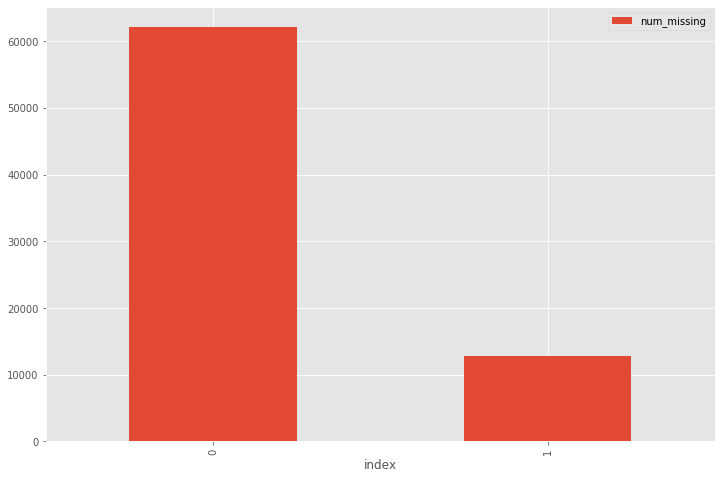

In [42]:
# сначала создаем индикатор для признаков с пропущенными данными
for col in df.columns:
    missing = df[col].isnull()
    num_missing = np.sum(missing)
    
    if num_missing > 0:  
        print('Пропущенные значения для : {}'.format(col))
        df['{}_ismissing'.format(col)] = missing


# затем на основе индикатора строим гистограмму
ismissing_cols = [col for col in df.columns if 'ismissing' in col]
df['num_missing'] = df[ismissing_cols].sum(axis=1)

df['num_missing'].value_counts().reset_index().sort_values(by='index').plot.bar(x='index', y='num_missing')

In [43]:
# отбрасываем строки с большим количеством пропусков
ind_missing = df[df['num_missing'] > 1].index
df_less_missing_rows = df.drop(ind_missing, axis=0)

In [44]:
len(df)

74907

In [45]:
df.columns

Index(['status', 'propertyType', 'street', 'homeFacts', 'city', 'schools',
       'sqft', 'zipcode', 'state', 'target', 'status_ismissing',
       'propertyType_ismissing', 'street_ismissing', 'city_ismissing',
       'sqft_ismissing', 'target_ismissing', 'num_missing', 'status2',
       'propertyType2', 'Yearbuilt', 'Remodeledyear', 'Heating', 'Cooling',
       'Parking', 'lotsize', 'Pricesqft', 'Pricesqft2', 'rating1', 'Distance1',
       'Grades1', 'target2', 'sqft2'],
      dtype='object')

In [46]:
df.head()

,status,propertyType,street,homeFacts,city,schools,sqft,zipcode,state,target,...,Cooling,Parking,lotsize,Pricesqft,Pricesqft2,rating1,Distance1,Grades1,target2,sqft2
2,for sale,single-family home,2005 Westridge Rd,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",LOSANGELES,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,CA,"$2,895,000",...,Central,AttachedGarage,8,'965',965,8/10,1.19,6-8,2895000,3000
3,for sale,single-family home,4311 Livingston Ave,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",DALLAS,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,TX,"$2,395,000",...,Central,DetachedGarage,8,'371',371,9/10,0.1,PK-4,2395000,6457
12,for sale,single-family home,16373 NW 16th St,"{'atAGlanceFacts': [{'factValue': '1996', 'fac...",PEMBROKEPINES,"[{'rating': ['8/10', '7/10', '7/10'], 'data': ...","2,839 sqft",33028,FL,"$525,000",...,Central,Carport,10,'185',185,7/10,0.92,PK-5,525000,2839
14,NaN,Single Family,15351 Falmouth Ave,"{'atAGlanceFacts': [{'factValue': '1982', 'fac...",HOUSTON,"[{'rating': ['4/10', '5/10', '7/10'], 'data': ...","2,454",77084,TX,"$168,800",...,Central,2spaces,2,'69',69,5/10,0.6,6-8,168800,2454
25,for sale,single-family home,1755 18th St NW,"{'atAGlanceFacts': [{'factValue': '1915', 'fac...",WASHINGTON,"[{'rating': ['10/10', '3/10'], 'data': {'Dista...","5,796 sqft",20009,DC,"$3,749,000",...,Central,OffStreet,2,'647',647,10/10,0.14,PK-5,3749000,5796


In [47]:
df.drop( [ 'street', 'sqft','homeFacts','schools','status', 
           'target','Pricesqft', 'propertyType'], axis='columns', inplace=True) 

In [48]:
df.head()

,city,zipcode,state,status_ismissing,propertyType_ismissing,street_ismissing,city_ismissing,sqft_ismissing,target_ismissing,num_missing,...,Heating,Cooling,Parking,lotsize,Pricesqft2,rating1,Distance1,Grades1,target2,sqft2
2,LOSANGELES,90049,CA,False,False,False,False,False,False,0,...,ForcedAir,Central,AttachedGarage,8,965,8/10,1.19,6-8,2895000,3000
3,DALLAS,75205,TX,False,False,False,False,False,False,0,...,ForcedAir,Central,DetachedGarage,8,371,9/10,0.1,PK-4,2395000,6457
12,PEMBROKEPINES,33028,FL,False,False,False,False,False,False,0,...,ForcedAir,Central,Carport,10,185,7/10,0.92,PK-5,525000,2839
14,HOUSTON,77084,TX,True,False,False,False,False,False,1,...,Other,Central,2spaces,2,69,5/10,0.6,6-8,168800,2454
25,WASHINGTON,20009,DC,False,False,False,False,False,False,0,...,Radiant,Central,OffStreet,2,647,10/10,0.14,PK-5,3749000,5796


In [49]:
df.target2 = df.target2.astype('float')
df.sqft2 = df.sqft2.astype('float')
df.Pricesqft2 = df.Pricesqft2.astype('float')
df.Distance1 = df.Distance1.astype('float')
df.lotsize = df.lotsize.astype('float')


In [52]:
# отбрасываем неуникальные строки
df_dedupped = df.drop_duplicates()
# сравниваем формы старого и нового наборов
print(df.shape)
print(df_dedupped.shape)

(74907, 24)
(74871, 24)


In [53]:
df = df.drop_duplicates()

In [54]:
#сохраняем 
df.to_csv('new_data1.csv')